Oversampling > 2x suggested for reliable results in Fresnel propagation.


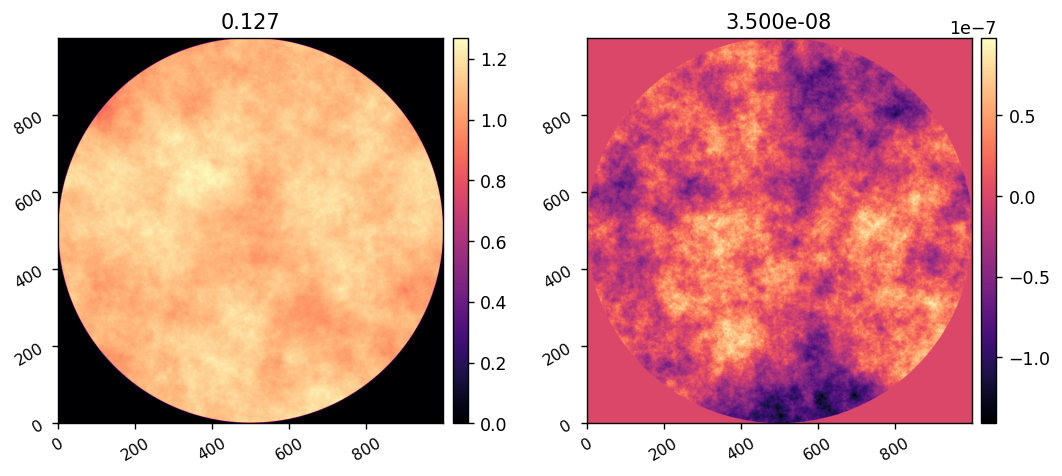

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*650e-9/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')


In [1]:
50/1.46484375e-05

3413333.3333333335

In [37]:
M.hres_win_size

1500

Oversampling > 2x suggested for reliable results in Fresnel propagation.


123 1200


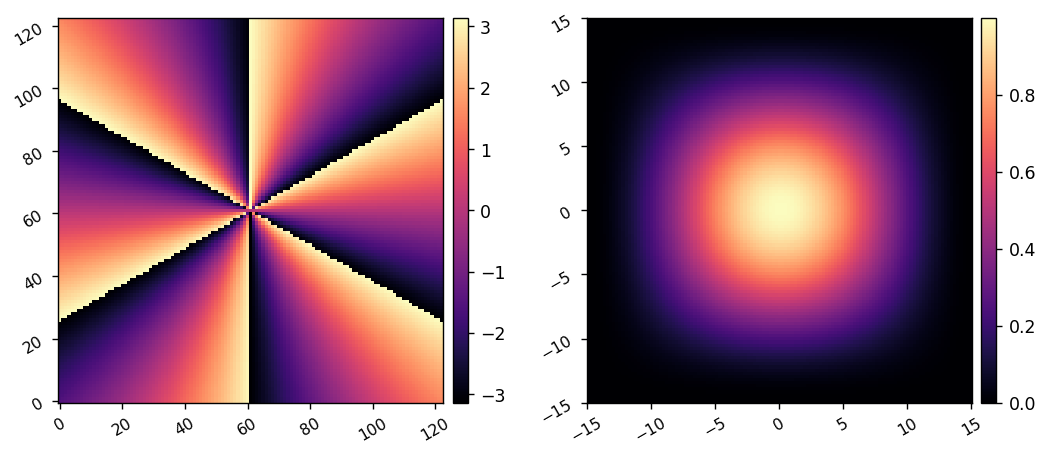

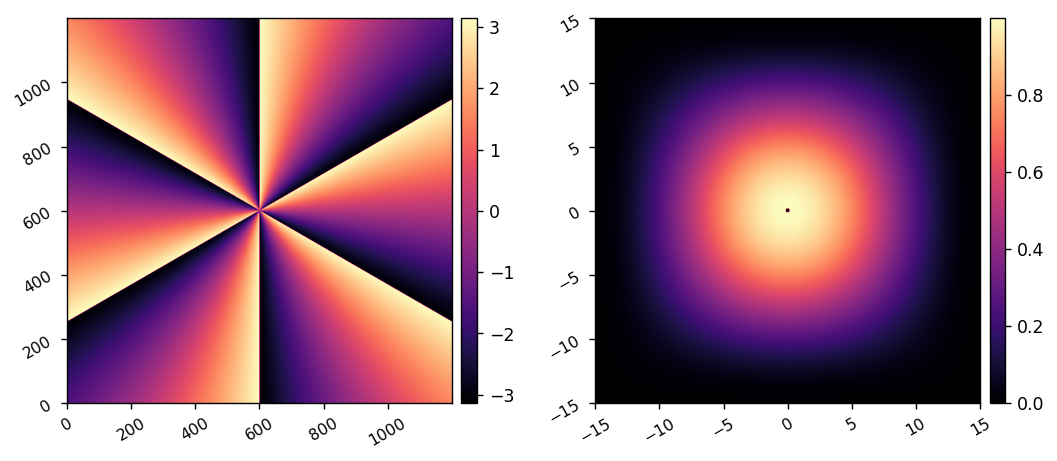

In [4]:
reload(ad_scoob)
M = ad_scoob.MODEL()

print(M.lres_win_size, M.hres_win_size,)
imshow2(xp.angle(M.vortex_lres), M.lres_window, 
        npix=M.lres_win_size,
        # npix1=M.lres_win_size, npix2=M.lres_win_size, 
        pxscl2=M.lres_sampling)
imshow2(xp.angle(M.vortex_hres), M.hres_window, 
        npix=M.hres_win_size,
        # npix1=M.hres_win_size, npix2=M.hres_win_size, 
        pxscl2=M.hres_sampling)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


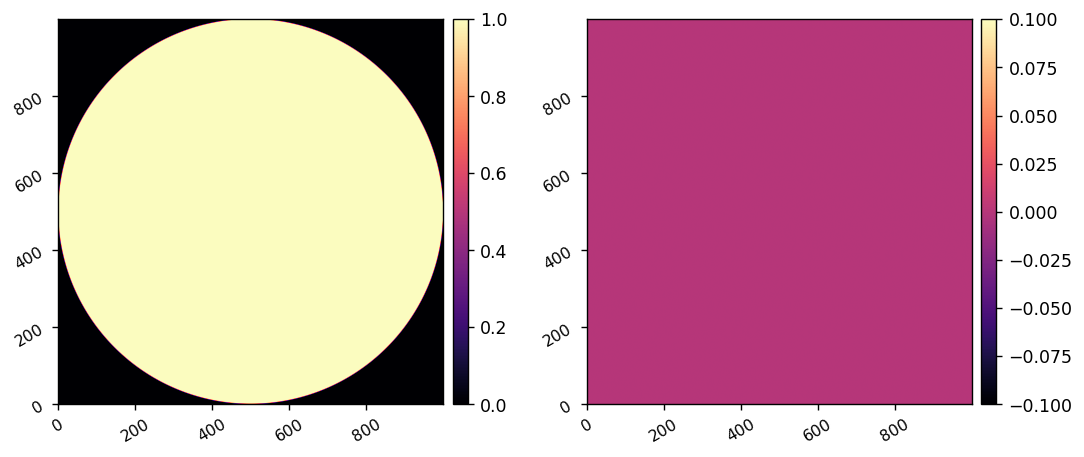

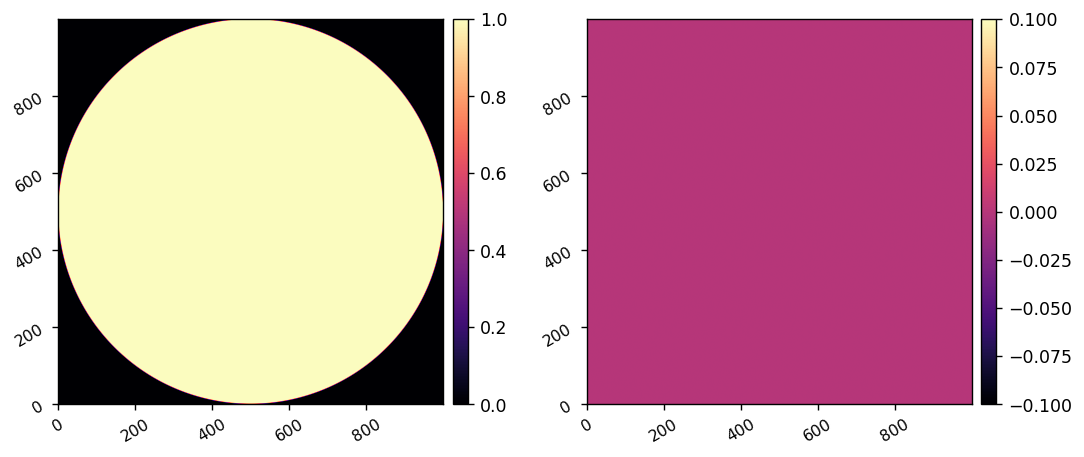

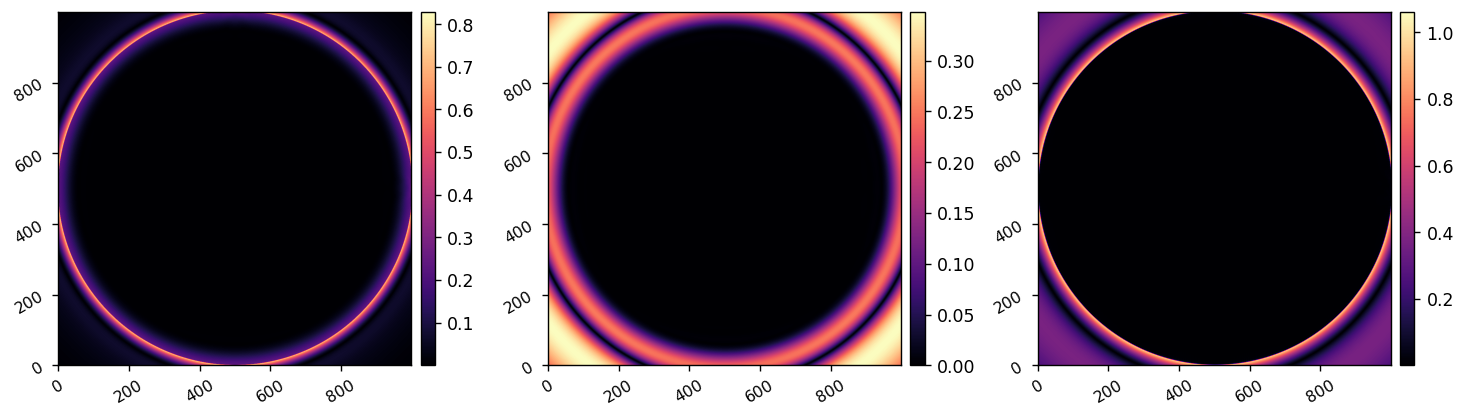

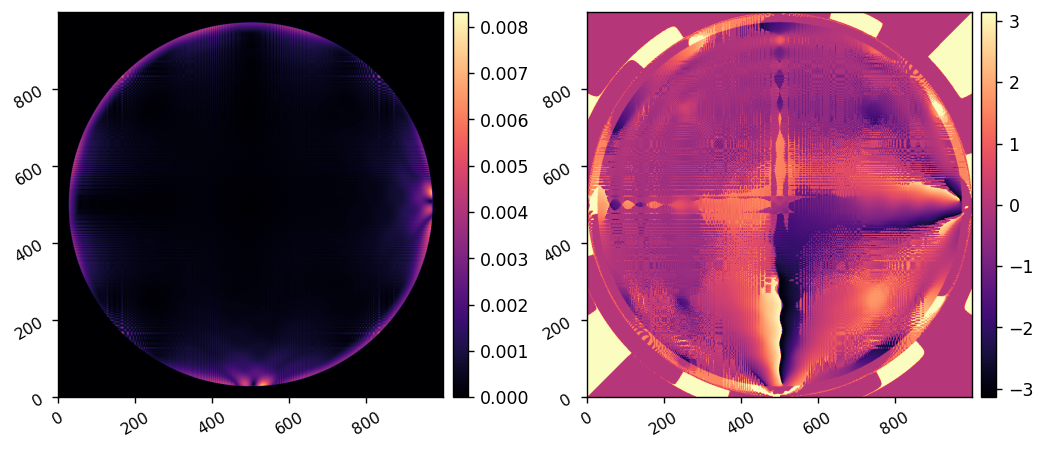

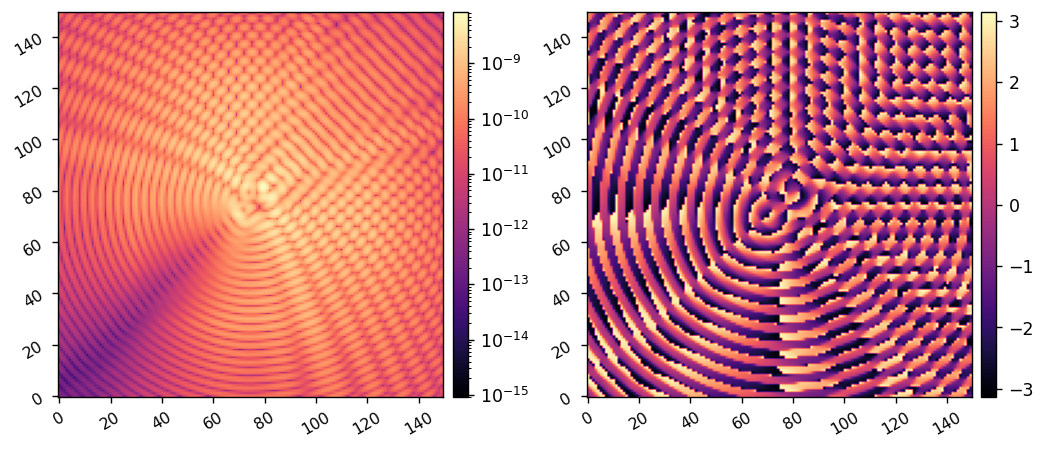

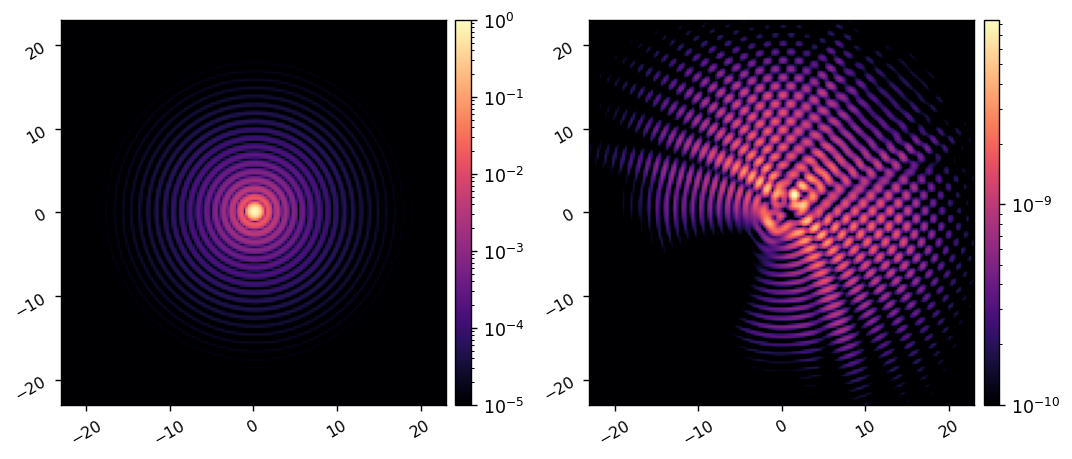

In [5]:
reload(ad_scoob)
m = ad_scoob.MODEL()

acts = np.zeros(m.Nacts)
ref_psf = m.snap(acts, use_vortex=False)
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, plot=True))**2
# ref_coro_im = m.snap(acts)

imshow2(ref_psf/m.Imax_ref, ref_coro_im,
        pxscl=m.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-10)


In [6]:
reload(ad_scoob)

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = m.forward(acts) * control_mask
r_cond = 1e-2

del_acts = np.zeros(m.Nacts)
J, dJ_dA = ad_scoob.val_and_grad(del_acts, m, acts, E_ab, r_cond, control_mask, verbose=True)

dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
print(dm_grad[25,21])
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True)

NameError: name 'control_mask' is not defined

In [11]:

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = m.forward(acts) * control_mask
r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(m.Nacts)
res = minimize(ad_scoob.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(m, acts, E_ab, r_cond, control_mask, True), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


0.11034877248431903 0.0 0.11034877248431903 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.47848D+06
0.0020935538943429996 2495701154.760924 0.11034877248431903 22616483161.311707
0.003292844048430549 35.3112334124922 0.11034877248431903 320.02645304966086


 This problem is unconstrained.


0.030789988355828427 2.2030584337467096 0.11034877248431903 20.243527606253853
0.3500777903816191 0.21279430565025348 0.11034877248431903 5.100846011783763
2.17156319572488 0.018028628400645088 0.11034877248431903 19.842466525277157
1.5298023289102831 0.0010601521637602746 0.11034877248431903 13.872945268073414
0.025205337115131128 4.918050281786171e-05 0.11034877248431903 0.22886088398978569

At iterate    1    f=  2.28861D-01    |proj g|=  1.31114D+06
0.007302088098094515 4.1166675302986746e-05 0.11034877248431903 0.06654586732662574

At iterate    2    f=  6.65459D-02    |proj g|=  2.71711D+05
0.003915297747741835 4.6110497118934874e-05 0.11034877248431903 0.03589897880761384

At iterate    3    f=  3.58990D-02    |proj g|=  1.84927D+05
0.0020772843288092116 5.444996051254536e-05 0.11034877248431903 0.019318151360720247

At iterate    4    f=  1.93182D-02    |proj g|=  1.10899D+05
0.0012125087925688332 6.1904319158133e-05 0.11034877248431903 0.011548955942469276

At iterate    5    

6.615633841985554e-05 2.9471555325695337e-07
0.0


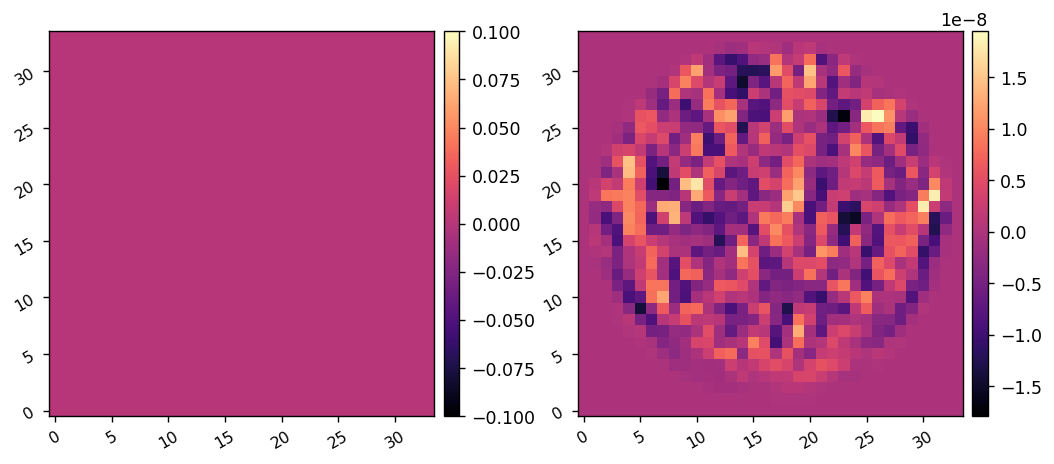

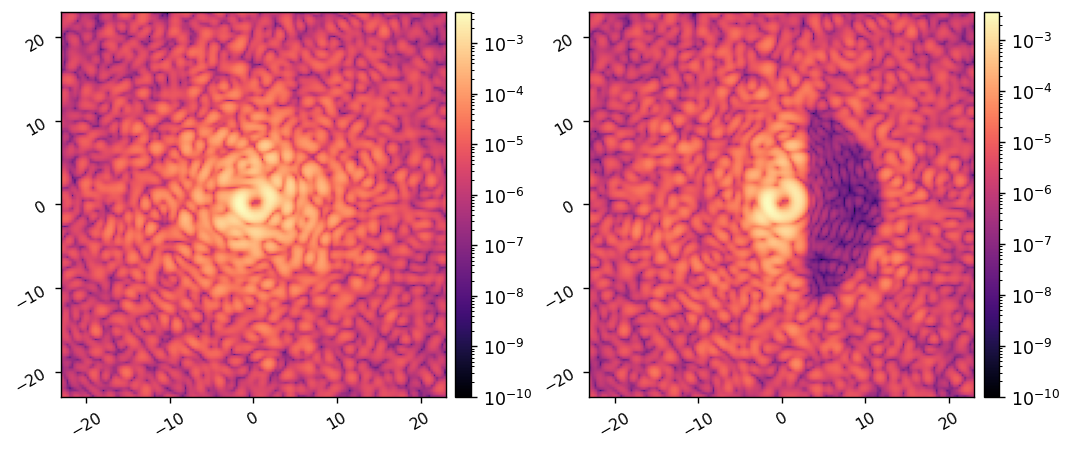

In [13]:
old_command = ad_scoob.acts_to_command(acts, m.dm_mask)
del_command = ad_scoob.acts_to_command(res.x, m.dm_mask)
old_im = m.snap(acts)
new_im = m.snap(acts + res.x)

print(xp.mean(old_im[control_mask]), xp.mean(new_im[control_mask]))
print(del_command[25,21])
imshow2(old_command, del_command)
imshow2(old_im, new_im, lognorm=True, pxscl=m.psf_pixelscale_lamD, vmin1=1e-10, vmin2=1e-10)

In [6]:
utils.save_fits('data/ad_test_acts.fits', res.x)

Saved data to:  data/ad_test_acts.fits


In [14]:
all_ims = []
all_efs = []
all_commands = []


In [18]:
reload(ad_scoob)
reload(adefc)

r_cond = 1e-2
r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

all_ims, all_efs, all_commands = adefc.sim(m, ad_scoob.val_and_grad, control_mask, 
                                            Nitr=3, 
                                            reg_cond=r_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=1,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )